In [1]:
import numpy as np
import pandas as 
import random
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp
from gensim.models import Word2Vec
import gensim
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")
pd.set_option('display.max_columns', 37)
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display_html 
from IPython.core.display import HTML
from collections import defaultdict
from surprise.model_selection import train_test_split
# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")
# Packages for saving models
import pickle
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
import scipy as sp
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from gensim.models import Word2Vec
from surprise.model_selection import cross_validate
import scipy.stats


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [2]:
sample_submission = pd.read_csv('/kaggle/input/edsa-movie-recommender/sample_submission.csv')
movies = pd.read_csv('/kaggle/input/edsa-movie-recommender/movies.csv')
imdb_data = pd.read_csv('/kaggle/input/edsa-movie-recommender/imdb_data.csv')
genome_scores = pd.read_csv('/kaggle/input/edsa-movie-recommender/genome_scores.csv')
genome_tags = pd.read_csv('/kaggle/input/edsa-movie-recommender/genome_tags.csv')
train = pd.read_csv('/kaggle/input/edsa-movie-recommender/train.csv')
test = pd.read_csv('/kaggle/input/edsa-movie-recommender/test.csv')
tags = pd.read_csv('/kaggle/input/edsa-movie-recommender/tags.csv')
links = pd.read_csv('/kaggle/input/edsa-movie-recommender/links.csv')

In [5]:
# Number of users
print('The ratings dataset has', train['userId'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', train['movieId'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', train['rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(train['rating'].unique()))

The ratings dataset has 162541 unique users
The ratings dataset has 48213 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [6]:
# Merge ratings and movies datasets
df = pd.merge(train, movies, on='movieId', how='inner')
# Take a look at the data
df.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [7]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()
# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7286 entries, 16 to 48032
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              7286 non-null   object 
 1   mean_rating        7286 non-null   float64
 2   number_of_ratings  7286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 227.7+ KB


In [8]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
34480,"Shawshank Redemption, The (1994)",4.417624,32831
14537,Forrest Gump (1994),4.047216,32383
31236,Pulp Fiction (1994),4.195097,31697
34840,"Silence of the Lambs, The (1991)",4.144172,29444
25144,"Matrix, The (1999)",4.154253,29014


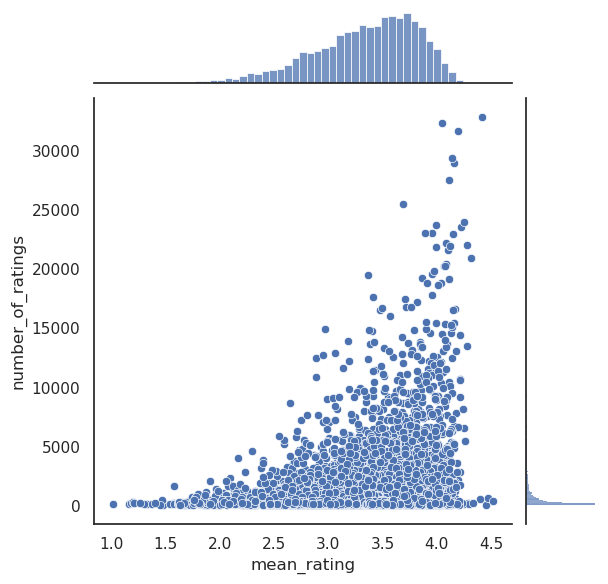

In [9]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [10]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9582662 entries, 0 to 9582661
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 511.8+ MB


In [11]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))


The ratings dataset has 162540 unique users
The ratings dataset has 7303 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [12]:
import random


# Calculate the number of rows in the DataFrame
n = df_GT100.shape[0]

# Calculate the sample size (1 percent of the original
s = n // 1000

# Generate the list of row indices to skip while sampling the DataFrame
skip_indices = random.sample(range(n), n - s)

# Sample the DataFrame by dropping the rows specified by the skip_indices list
sampled_df = df_GT100.drop(skip_indices)

# Number of users in the sampled dataframe
print('The sampled dataframe has', sampled_df['userId'].nunique(), 'unique users')

# Number of movies in the sampled dataframe
print('The sampled dataframe has', sampled_df['movieId'].nunique(), 'unique movies')

# Now you have a sampled dataframe with 0.1 percent of the original data, and you can proceed with your analysis using this sampled data.

The sampled dataframe has 8729 unique users
The sampled dataframe has 3186 unique movies


In [50]:
sampled_df.tail(50)

,userId,movieId,rating,timestamp,title,genres
9540827,156863,3127,2.5,1068529047,Holy Smoke (1999),Comedy|Drama
9542213,116233,2757,4.0,1358261819,Frances (1982),Drama
9542547,135837,195497,3.5,1563910008,Vice (2018),Comedy|Drama
9542979,60749,86781,4.0,1493366102,Incendies (2010),Drama|Mystery|War
9543536,17780,57183,4.5,1563309510,Like Stars on Earth (Taare Zameen Par) (2007),Drama
9547337,33041,5521,1.5,1155599454,"Principal, The (1987)",Action|Crime|Drama
9548615,20055,1703,2.0,1163313922,For Richer or Poorer (1997),Comedy
9549078,44585,89087,3.5,1320987890,Colombiana (2011),Action|Adventure|Drama|Thriller
9549902,56917,202,4.5,1362266279,Total Eclipse (1995),Drama|Romance
9552266,124647,4428,3.0,1005153832,"Misfits, The (1961)",Comedy|Drama|Romance|Western


In [14]:
# Create user-item matrix
matrix = sampled_df.pivot_table(index='userId', columns='title', values='rating')

In [15]:
matrix.head(5)

title,"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),12 Angry Men (1957),12 Rounds (2009),12 Years a Slave (2013),127 Hours (2010),13 Assassins (Jûsan-nin no shikaku) (2010),13 Going on 30 (2004),13 Hours (2016),...,Young Guns II (1990),"Young Victoria, The (2009)",Your Friends and Neighbors (1998),Your Name. (2016),Youth in Revolt (2009),Yu-Gi-Oh! (2004),Zeitgeist: The Movie (2007),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')

In [17]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))

In [18]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,3,57,75,80,107,132,142,169,171,181,187,196,221,302,418,462,501,512,...,162209,162263,162286,162297,162309,162328,162399,162403,162433,162445,162447,162465,162466,162480,162495,162516,162529,162533
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
user_similarity_cosine

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
def predict_rating(user_similarity_cosine, matrix, picked_user_id, unseen_movie_id, n=5):
    # Find the most similar users for the given user based on the user similarity matrix
    similar_users = np.argsort(matrix[picked_user_id])[::-1][1:n+1]
    
    # Get the ratings of the most similar users for the unseen_movie_id
    similar_user_ratings = user_movie_matrix.loc[similar_users, unseen_movie_id]
    
    # Calculate the predicted rating as the weighted average of similar user ratings
    # You can use different strategies for weighting, e.g., taking the mean or using the similarity as weights
    predicted_rating = similar_user_ratings.mean()
    
    return predicted_rating




In [57]:
picked_user_id = 79
unseen_movie_id = 70361
predicted_rating = predict_rating(user_similarity_cosine, matrix, picked_user_id, unseen_movie_id)
print("Predicted rating for user", picked_user_id, "and movie", unseen_movie_id, ":", predicted_rating)



KeyError: 79

In [ ]:
def predict_rating(user_similarity_matrix, user_movie_matrix, picked_user_id, unseen_movie_id, n=10):
    # Find the most similar users to picked_user_id based on cosine similarity
    similar_users = np.argsort(user_similarity_matrix[picked_user_id])[::-1][1:n+1]
    
    # Get the ratings of the most similar users for the unseen_movie_id
    similar_user_ratings = user_movie_matrix[similar_users, unseen_movie_id]
    
    # Get the cosine similarity values for the most similar users
    similarity_values = user_similarity_matrix[picked_user_id, similar_users]
    
    # Calculate the predicted rating as the weighted average of the ratings from the most similar users
    predicted_rating = np.dot(similarity_values, similar_user_ratings) / np.sum(similarity_values)
    
    return predicted_rating


In [19]:

# Find the number of unique values in the user similarity matrix
num_unique_values = user_similarity.nunique().sum()

print("Number of unique values in the user similarity matrix:", num_unique_values)

Number of unique values in the user similarity matrix: 614


In [20]:
user_similarity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8729 entries, 3 to 162533
Columns: 8729 entries, 3 to 162533
dtypes: float64(8729)
memory usage: 581.6 MB


In [29]:
# Pick a user ID
picked_userid = 162516

In [30]:
# Number of similar users
n = 3
# User similarity threashold
user_similarity_threshold = 0.3
# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]
# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)


The similar users for user 162516 are userId
162516    1.0
Name: 162516, dtype: float64
